<a href="https://colab.research.google.com/github/ballmdr/Machine-Learning/blob/master/Forex_Prediction_Neural_Network_Pure_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pickle

from datetime import datetime
from keras.utils import to_categorical

from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
filename = '/content/drive/My Drive/export/M30_all_GBPUSD.csv'
df = pd.read_csv(filename, names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Datetime'] = pd.to_datetime(df.Date + ' ' + df.Time)
df.set_index('Datetime', inplace=True)

# Features for Momentum Strategy
df['Returns'] = - df.Close.pct_change(-1)

df['MA35'] = df.Close.rolling(35).mean()
df['MA70'] = df.Close.rolling(70).mean()
df['MA200'] = df.Close.rolling(200).mean()

# ma35 > ma70 = bullish
df['35_70'] = np.where(df.MA35 >= df.MA70, 1, 0)

# price > ma200 = bullish
df['bias_trend'] = np.where(df.Close.values >= df.MA200, 1, 0) 

df['body_candles'] = df.Open - df.Close
df['high_low'] = df.High - df.Low

df.dropna(inplace=True)

def norm_features(x):
  return (x - x.mean()) / (x.max() - x.min())

# normalize
df['Returns'] = norm_features(df.Returns)
df['Volume'] = norm_features(df.Volume)
df['body_candles'] = norm_features(df.body_candles)
df['high_low'] = norm_features(df.high_low)

df['Target'] = np.zeros((len(df)))
df['Target'].loc[df.Returns > df.Returns.quantile(.20)] = 1
df['Target'].loc[df.Returns > df.Returns.quantile(.80)] = 2
#df['Target'].loc[df.Returns > df.Returns.quantile(.60)] = 3
#df['Target'].loc[df.Returns > df.Returns.quantile(.80)] = 4

df['Time_h4'] = np.zeros((len(df)))
df['Time_h4'].loc[df.Time >= '04:00'] = 1
df['Time_h4'].loc[df.Time >= '08:00'] = 2
df['Time_h4'].loc[df.Time >= '12:00'] = 3
df['Time_h4'].loc[df.Time >= '16:00'] = 4
df['Time_h4'].loc[df.Time >= '20:00'] = 5

time_h4 = pd.DataFrame(to_categorical(df.Time_h4, num_classes=6))
time_h4 = time_h4.set_index(df.index)
time_h4.columns = ['00:00', '04:00', '08:00', '12:00', '16:00', '20:00']

df = pd.concat([df, time_h4], axis=1)

df.drop(['Date', 'Time', 'Time_h4', 'Open', 'High', 'Low', 'Close', 'Returns', 'MA35', 'MA70', 'MA200'], axis=1, inplace=True)

X = df.drop(['Target'], axis=1).values
Y = df.Target.values


# convert y into categorical
K = 3

Y = to_categorical(Y, num_classes=K)

# split train test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

print('train shape: ', x_train.shape)
print('test shape: ', x_test.shape)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


train shape:  (135535, 11)
test shape:  (58087, 11)


In [9]:
df

,Volume,35_70,bias_trend,body_candles,high_low,Target,00:00,04:00,08:00,12:00,16:00,20:00
Datetime,,,,,,,,,,,,
2003-08-08 03:30:00,-0.007071,1,1,-0.003786,-0.010676,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2003-08-08 04:00:00,-0.006605,1,1,0.002013,-0.014129,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2003-08-08 04:30:00,-0.007337,1,1,0.001608,-0.015281,2.0,0.0,1.0,0.0,0.0,0.0,0.0
2003-08-08 05:00:00,-0.006892,1,1,-0.012013,0.002132,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2003-08-08 05:30:00,-0.007158,1,1,-0.007023,-0.001754,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2003-08-08 06:00:00,-0.006583,1,1,-0.000414,-0.009812,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2003-08-08 06:30:00,-0.006741,1,1,-0.000010,-0.011107,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2003-08-08 07:00:00,-0.006978,1,1,0.026153,0.023718,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2003-08-08 07:30:00,-0.006411,1,1,0.021298,0.022710,1.0,0.0,1.0,0.0,0.0,0.0,0.0


0 cost:  1.6403670748852122  acc:  29.84
10 cost:  1.2124479244714437  acc:  36.35
20 cost:  1.06404886149856  acc:  40.25
30 cost:  0.9493954609122799  acc:  45.57
40 cost:  0.8430549717379872  acc:  48.82
50 cost:  0.7522367635131165  acc:  49.09
60 cost:  0.6872351008897872  acc:  48.74
70 cost:  0.6458686179726948  acc:  48.14
80 cost:  0.6170436166026049  acc:  48.21
90 cost:  0.5941273014416861  acc:  47.96
100 cost:  0.5748716489439365  acc:  48.03
110 cost:  0.5583962882434892  acc:  50.54
120 cost:  0.5441282180842089  acc:  52.89
130 cost:  0.5315965256839555  acc:  54.73
140 cost:  0.5204163014924736  acc:  54.87
150 cost:  0.5102922518506577  acc:  54.63
160 cost:  0.5010115886704273  acc:  54.54
170 cost:  0.492428089673862  acc:  55.6
180 cost:  0.4844437878748127  acc:  55.6
190 cost:  0.47699251846099194  acc:  55.53
200 cost:  0.47002704403986945  acc:  55.53
210 cost:  0.4635100431680637  acc:  55.55
220 cost:  0.45740857356058123  acc:  55.65
230 cost:  0.45169129320

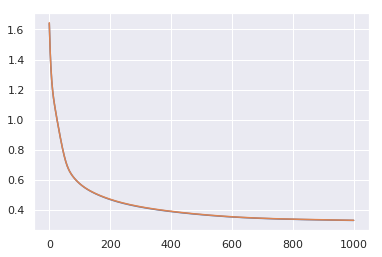

Train score:  59.08
Test score:  59.05


In [10]:
# build Neural Network using Numpy

def softmax(a):
  a = np.exp(a)
  return a / a.sum(axis=1, keepdims=True)

def cross_entropy(t, y):
  return - np.mean(t * np.log(y))

def model_score(t, y):
  return np.round(np.mean(t == y)*100, 2)

def predict(y):
  return np.argmax(y, axis=1)

def relu(z):
  return z * (z > 0)

def tanh(z):
  return np.tanh(z)

D = X.shape[1]
hidden_layer = 64
lr = 0.0000001
epochs = 1000

init = false
#runned 1000

if init:
  w1 = np.random.randn(D, hidden_layer)
  b1 = np.random.randn(hidden_layer)
  w2 = np.random.randn(hidden_layer, K)
  b2 = np.random.randn(K)
else:
  with open('/content/drive/My Drive/Colab Notebooks/w1.pickle', 'rb') as file:
    w1 = pickle.load(file)
  with open('/content/drive/My Drive/Colab Notebooks/b1.pickle', 'rb') as file:
    b1 = pickle.load(file)
  with open('/content/drive/My Drive/Colab Notebooks/w2.pickle', 'rb') as file:
    w2 = pickle.load(file)
  with open('/content/drive/My Drive/Colab Notebooks/b2.pickle', 'rb') as file:
    b2 = pickle.load(file)

train_costs = []
test_costs = []
train_acc = []
test_acc = []

for i in range(epochs):
  # train
  z_train = tanh(x_train.dot(w1) + b1)
  y_pred_train = softmax(z_train.dot(w2) + b2)
  cost_train = cross_entropy(y_train, y_pred_train)
  train_costs.append(cost_train)
  train_score = model_score(predict(y_train), predict(y_pred_train))
  train_acc.append(train_score)
  
  # test
  z_test = tanh(x_test.dot(w1) + b1)
  y_pred_test = softmax(z_test.dot(w2) + b2)
  cost_test = cross_entropy(y_test, y_pred_test)
  test_costs.append(cost_test)
  test_score = model_score(predict(y_test), predict(y_pred_test))
  test_acc.append(test_score)
  
  if i % 10 == 0:
    print(i, 'cost: ', cost_train, ' acc: ', train_score)
  
  delta = y_train - y_pred_train
  w2 += z_train.T.dot(delta) * lr
  b2 += np.sum(delta) * lr
  
  dz = delta.dot(w2.T) * (1 - np.power(z_train, 2))
  
  w1 += x_train.T.dot(dz) * lr
  b1 += np.sum(dz) * lr
  
  
plt.plot(train_costs)
plt.plot(test_costs)
plt.show()

print('Train score: ', model_score(predict(y_train), predict(y_pred_train)))
print('Test score: ', model_score(predict(y_test), predict(y_pred_test)))
  
  
with open('/content/drive/My Drive/Colab Notebooks/w1.pickle', 'wb') as file:
  pickle.dump(w1, file)

with open('/content/drive/My Drive/Colab Notebooks/b1.pickle', 'wb') as file:
  pickle.dump(b1, file)
  
with open('/content/drive/My Drive/Colab Notebooks/w2.pickle', 'wb') as file:
  pickle.dump(w2, file)

with open('/content/drive/My Drive/Colab Notebooks/b2.pickle', 'wb') as file:
  pickle.dump(b2, file)

Train on 135535 samples, validate on 58087 samples
Epoch 1/80
135535/135535 [==============================] - 11s 83us/sample - loss: 1.0882 - acc: 0.3523 - val_loss: 1.0880 - val_acc: 0.3498
Epoch 2/80
135535/135535 [==============================] - 11s 82us/sample - loss: 1.0863 - acc: 0.3544 - val_loss: 1.0861 - val_acc: 0.3531
Epoch 3/80
135535/135535 [==============================] - 11s 82us/sample - loss: 1.0844 - acc: 0.3634 - val_loss: 1.0843 - val_acc: 0.3730
Epoch 4/80
135535/135535 [==============================] - 11s 85us/sample - loss: 1.0826 - acc: 0.3919 - val_loss: 1.0825 - val_acc: 0.3933
Epoch 5/80
135535/135535 [==============================] - 11s 84us/sample - loss: 1.0808 - acc: 0.3960 - val_loss: 1.0807 - val_acc: 0.3940
Epoch 6/80
135535/135535 [==============================] - 11s 83us/sample - loss: 1.0790 - acc: 0.3967 - val_loss: 1.0790 - val_acc: 0.3944
Epoch 7/80
135535/135535 [==============================] - 11s 84us/sample - loss: 1.0773 - acc:

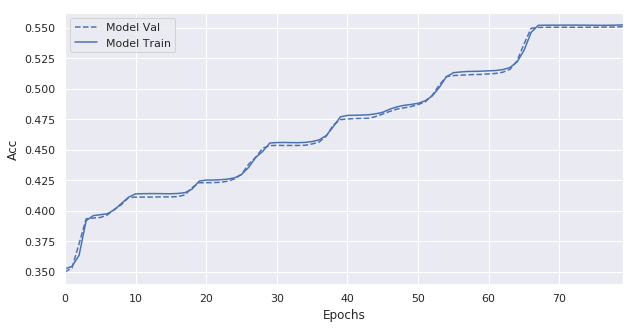

In [19]:
# use keras for comparision
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='loss', mode='min')

model = Sequential([
    Dense(64, input_shape=(X.shape[1],), activation=tf.nn.tanh),
    Dense(K, activation=tf.nn.softmax)
])
model.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

init = False
if not init:
    model.load_weights('/content/drive/My Drive/Colab Notebooks/my_model_weights.h5')

epochs = 80
#runned 100

history = model.fit(x_train, y_train, epochs=epochs, callbacks=[early_stop], validation_split=0.3, validation_data=(x_test, y_test), batch_size=32, verbose=1)

def history_plot(histories, key='acc'):
    plt.figure(figsize=(10,5))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()

        plt.xlim([0,max(history.epoch)])
        
history_plot([('model', history)])

model.save_weights('/content/drive/My Drive/Colab Notebooks/my_model_weights.h5')